In [98]:
import re
import random
import pandas as pd
import hashlib

In [ ]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [100]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Open Source/GitHub,102.469143,51.234571,67.710613,2
VMWare,249.629836,5.805345,24.916574,43
WSL + Kali Linux,456.017120,76.002853,171.191448,6
C# Basics,655.487906,21.144771,65.926751,31
Azure Private DNS,819.835120,43.149217,109.056914,19
Azure Compute Gallery,825.493030,20.637326,90.528981,40
Logging in Python,902.764870,64.483205,213.823838,14
Azure AD Authentication,1012.470692,77.882361,249.734114,13
Azure Functions + Visual Studio,1051.595945,80.891996,179.028918,13
Email Auth and Security,1069.012217,89.084351,238.708707,12


# Histogram

sum of ages: ~51579.13


<Axes: >

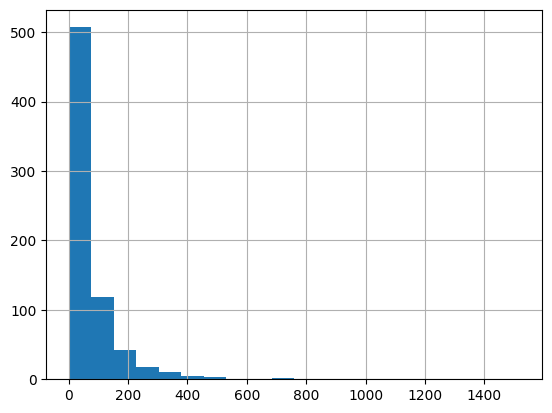

In [101]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [102]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [103]:
existing_cards = existing_cards.sort_values('age', ascending=False)
remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 711
Total card age: 51579.13


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
107,Debugging in VS Code,Debugger API\nAn application programming inter...,379ed80170d7da4e8ca2e7b1a4b9527c,1518.215503,163.149606,1518.215503,2936.692916,0.002639
67,Vocab,"Red Side Story, FForde\nParboil\nPronunciation...",1ee9362f92872e44aac4c6b02749add8,1090.108490,81.464111,1090.108490,6598.592998,0.014233
246,Azure Developer Associate,Front: How do you exclude a nested JSON proper...,325d059c5f36af8a84a342578e7e7679,880.208777,115.065939,880.208777,5983.428823,0.991186
481,Azure Developer Associate,What Azure Monitor feature uses metric alerts ...,c43f9ff638b68890b293d079ffdd92f2,716.016501,115.065939,880.208777,5983.428823,0.991186
372,PnP PowerShell,Invoke-RestMethod (Microsoft.PowerShell.Utilit...,178d8c43f16d97225067ce4d3dcc87af,697.189790,74.723589,697.189790,4558.138911,0.050026
340,Python,How can you re-raise an exception after handli...,e45bf01ce9d388ab3e680ad1f6f45db8,607.501195,111.789048,607.501195,4359.772868,0.033382
247,Azure Developer Associate,How do you get notified when an Azure web app’...,397c5c15f2709167fe5b678c88f8a128,547.114716,115.065939,880.208777,5983.428823,0.991186
573,Python,Q:\nWhich keyword is used to define a generato...,f7dc92b45b9a788daad8519bc3a409c8,520.717968,111.789048,607.501195,4359.772868,0.033382
311,Vocab,Grapheme\nnoun\nSPA: GRAP-heem\nIPA: /ˈɡræfiːm...,8f4fc671f33b822f1aea884b8bc5888a,518.752563,81.464111,1090.108490,6598.592998,0.014233
118,Audit Report Tracker (Sharepoint List),View (SharePoint View)\nDefinition: A pre-defi...,c9375efcef5b15bae0f26f4f8d80a3f7,493.803650,148.645237,493.803650,1635.097610,0.314809


# Headers with fewest notes first

In [104]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [105]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [106]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [107]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [108]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [109]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [110]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [111]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [112]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [113]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [114]:
existing_cards.sort_values('age', ascending=False).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
107,Debugging in VS Code,Debugger API\nAn application programming inter...,379ed80170d7da4e8ca2e7b1a4b9527c,1518.215503,163.149606,1518.215503,2936.692916,0.002639
67,Vocab,"Red Side Story, FForde\nParboil\nPronunciation...",1ee9362f92872e44aac4c6b02749add8,1090.108490,81.464111,1090.108490,6598.592998,0.014233
246,Azure Developer Associate,Front: How do you exclude a nested JSON proper...,325d059c5f36af8a84a342578e7e7679,880.208777,115.065939,880.208777,5983.428823,0.991186
481,Azure Developer Associate,What Azure Monitor feature uses metric alerts ...,c43f9ff638b68890b293d079ffdd92f2,716.016501,115.065939,880.208777,5983.428823,0.991186
372,PnP PowerShell,Invoke-RestMethod (Microsoft.PowerShell.Utilit...,178d8c43f16d97225067ce4d3dcc87af,697.189790,74.723589,697.189790,4558.138911,0.050026
340,Python,How can you re-raise an exception after handli...,e45bf01ce9d388ab3e680ad1f6f45db8,607.501195,111.789048,607.501195,4359.772868,0.033382
247,Azure Developer Associate,How do you get notified when an Azure web app’...,397c5c15f2709167fe5b678c88f8a128,547.114716,115.065939,880.208777,5983.428823,0.991186
573,Python,Q:\nWhich keyword is used to define a generato...,f7dc92b45b9a788daad8519bc3a409c8,520.717968,111.789048,607.501195,4359.772868,0.033382
311,Vocab,Grapheme\nnoun\nSPA: GRAP-heem\nIPA: /ˈɡræfiːm...,8f4fc671f33b822f1aea884b8bc5888a,518.752563,81.464111,1090.108490,6598.592998,0.014233
118,Audit Report Tracker (Sharepoint List),View (SharePoint View)\nDefinition: A pre-defi...,c9375efcef5b15bae0f26f4f8d80a3f7,493.803650,148.645237,493.803650,1635.097610,0.314809


In [115]:
existing_cards.head(10).sum()

head                   Debugging in VS CodeVocabAzure Developer Assoc...
body                   Debugger API\nAn application programming inter...
hash                   379ed80170d7da4e8ca2e7b1a4b9527c1ee9362f92872e...
age                                                          7589.629153
subject_mean_age                                             1118.222567
subject_highest_age                                          8745.054643
subject_age_sum                                             48996.947639
head_random_roll                                                3.436261
dtype: object

In [116]:
existing_cards['age'].mean()

72.54448293570812